When using Bayesian techniques, the result is a probability distribution of possible values. Usually, one has to take that distribution and turn it into usable values, to insert into a function or what have you. Sometimes, this is trivial, while in others more care must be used. In this notebook I artificially generate some "parameters" and attempt to extract them from a noisy distribution using expectation maximization techniques. 

###Packages
I'll be using scikit-learn for this example, along with it's dependencies. 

Installation instructions can be found here: http://scikit-learn.org/stable/install.html

It can be installed with pip, but you may want to check that you have all the dependencies before installing. 

###Artificial Data
I'll start by generating the artificial data. In my image fitting algorithm the MCMC produces samples for amplitdue and radius. Almost always, there are 2 gaussian-like peaks in the data. Therefore, I will select "true" parameters and create noisy gaussians around them. 

In [9]:
import numpy as np
from time import time
#seed the random number generator
#use int(time()) for real pseuo-randomness
np.random.seed(2)
#random true values
trueAmps = np.array([1.2*np.random.rand(), np.random.rand()+1.3])
trueRads = np.array([.5*np.random.rand(), .7+1.5*np.random.rand()])
print trueAmps
print trueRads

size = 10**4 #the number of sample points to generate
weights = np.array([1-.2, .2]) #the relative signal strength between the 2 peaks


#A lot going on here. Create random gaussian noise of size size and add it to the true value.
#then, reshape to have an array of shape (2*size,)
#This is the form that comes back from the MCMC sampler. 
noiseMag = 1.5 #the magnitutde of the noise.
sampledAmps = np.array(noiseMag*np.random.randn(size, 2)*weights+trueAmps).reshape((-1))
sampledRads = np.array(noiseMag*np.random.randn(size, 2)*weights+trueRads).reshape((-1))
data = np.c_[sampledAmps, sampledRads]

[ 0.52319388  1.32592623]
[ 0.27483124  1.35298359]


Below, I plot 2 histograms of our samples so we know what we've got.

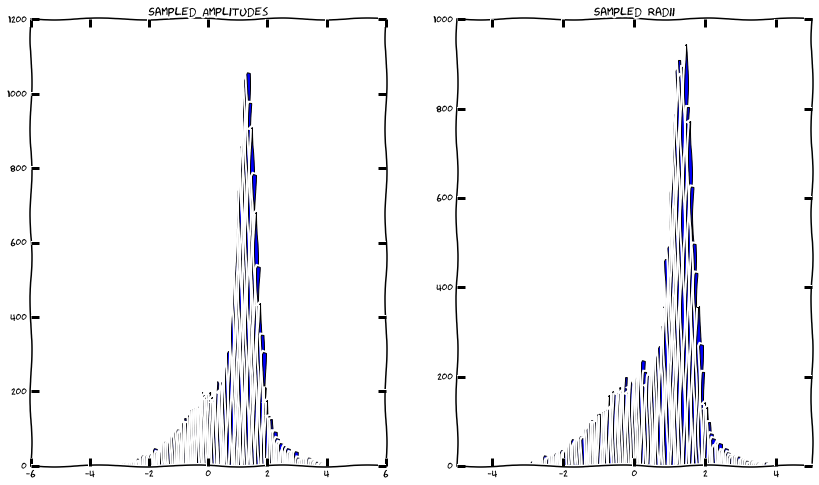

In [10]:
from matplotlib import pyplot as plt
plt.xkcd()
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(14,8)
plt.subplot(121)
plt.title('Sampled Amplitudes')
plt.hist(sampledAmps, bins = 150)
plt.subplot(122)
plt.title('Sampled Radii')
plt.hist(sampledRads, bins = 150)
plt.show()

If you have triangle, I use it below to get a view of the 2-D situation. If you don't, you can install it with:

In [3]:
%%bash
pip install triangle_plot

Cleaning up...


Only one of the 2 true values are shown below in blue on the plot. 

/home/jeffrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/home/jeffrey/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


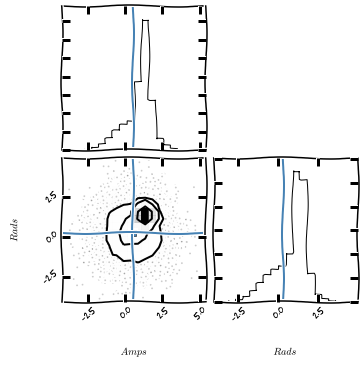

In [3]:
from triangle import corner
fig = corner(data, labels = ["$Amps$", "$Rads$"], truths = np.r_[trueAmps[0], trueRads[0]] )

###Expectation Maximization

Now, I'll apply scikit's mixture model to the data we've generated.

Recovered Vals:
[ 0.49928935  0.25016246]
[ 1.32085807  1.34859856]
True Vals:
0.52319388257 0.274831238939
1.32592623183 1.35298358893


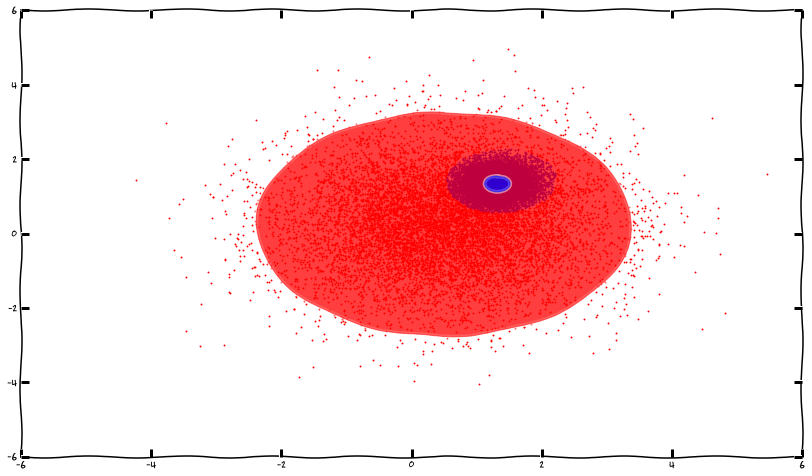

In [11]:
from sklearn import mixture
from scipy import linalg
from matplotlib.patches import Ellipse

#a Gaussian Mixture Model of 2 components and full covariance. 
gmm = mixture.GMM(n_components = 2, covariance_type = 'full')
gmm.fit(data)

print "Recovered Vals:"
for mean in gmm.means_:
    print mean
    
print 'True Vals:'
for i in xrange(2):
    print trueAmps[i],trueRads[i]

classify = gmm.predict(data) #classify each point as in one peak or the other.
colors = ['r', 'b']
splot = plt.subplot(111)
#iterate over the gaussians that have been fit to
for i,(mean, covar,color) in enumerate(zip(gmm.means_, gmm.covars_, colors)):
    #eigenvalues and eigenvectors of covar matrix
    v,w = linalg.eigh(covar)
    
    #plot the points in the data
    plt.scatter(data[classify==i, 0], data[classify==i,1], .8, color = color)
    #Plot an ellipse
    v*=4
    #plot a semi tranparent ellipse over the data
    ell = Ellipse(mean, v[0], v[1], 180, color = color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)
    
plt.show()

###Real Data
That was pretty easy, and worked pretty well. However, that was a little bit child's play, because some real data is not nearly so nice. Below I plot the real data for comparison.

In [12]:
#Make sure to change this to whatever it is on your machine.
filename = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/Samples/CFHTLS_047_0155_g'

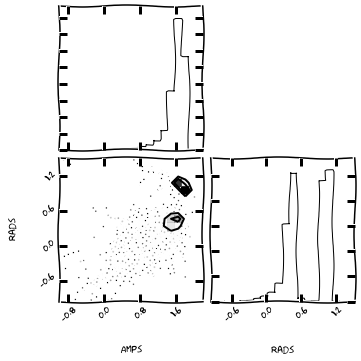

In [9]:
samples = np.loadtxt(filename, delimiter = ',')
sampled_amps = samples[:, :2].reshape((-1))
sampled_rads = samples[:, 2:].reshape((-1))
data = np.c_[sampled_amps, sampled_rads]

fig = corner(data, labels = ['Amps', 'Rads'])
plt.show()

Not nearly as nice or symmetrical. Let's see how scikit does. 

Recovered Vals:
[ 1.32085944  1.34860086]
[ 0.49930371  0.25018116]


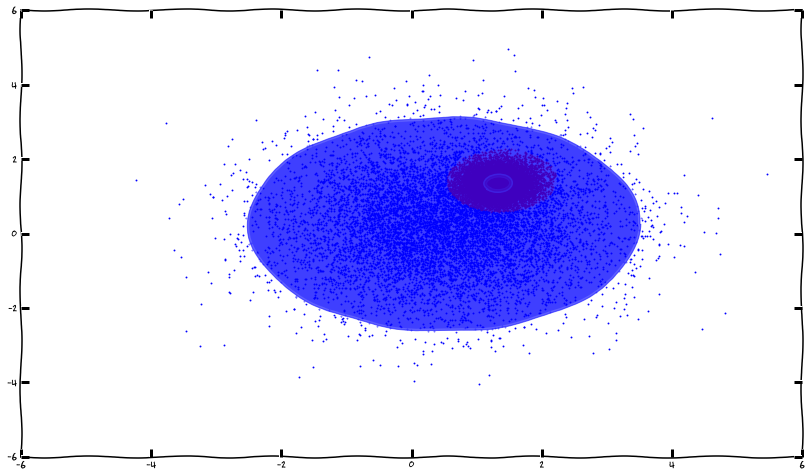

In [13]:
#This is just copied and pasted from above. 

#a Gaussian Mixture Model of 2 components and full covariance. 
gmm = mixture.GMM(n_components = 2, covariance_type = 'full')
gmm.fit(data)

print "Recovered Vals:"
for mean in gmm.means_:
    print mean

classify = gmm.predict(data) #classify each point as in one peak or the other.
colors = ['r', 'b']
splot = plt.subplot(111)
#iterate over the gaussians that have been fit to
for i,(mean, covar,color) in enumerate(zip(gmm.means_, gmm.covars_, colors)):
    #eigenvalues and eigenvectors of covar matrix
    v,w = linalg.eigh(covar)
    
    #plot the points in the data
    plt.scatter(data[classify==i, 0], data[classify==i,1], .8, color = color)
    #Plot an ellipse
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180*angle/np.pi
    v*=4
    #plot a semi tranparent ellipse over the data
    ell = Ellipse(mean, v[0], v[1], 180+angle, color = color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)
    
plt.show()

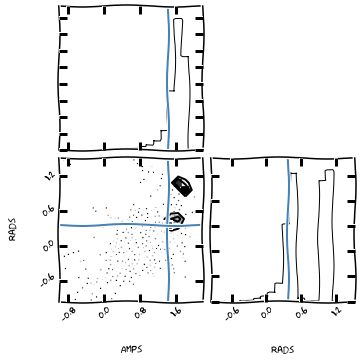

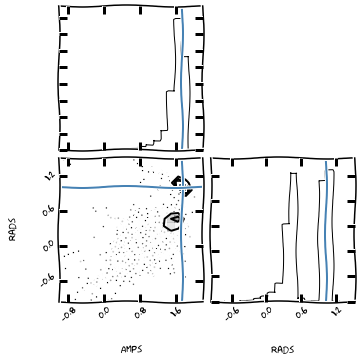

In [11]:
fig = corner(data, labels = ['Amps', 'Rads'], truths = gmm.means_[0])
plt.show()
fig = corner(data, labels = ['Amps', 'Rads'], truths = gmm.means_[1])
plt.show()

Hey, not bad! The second one didn't fair so well, though. It's worth noting that the sample data more strongly resembles an exponential distribution than a normal one. Let's generate some more challenging test data. 

###More Complex Test Data
I've added a bit of an exponential flavor to the the test data. Notice that it more strongly resembles the sampled data.

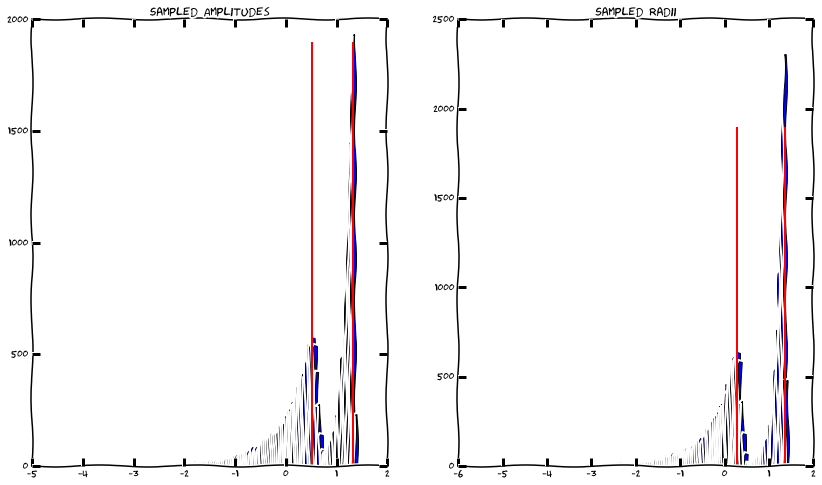

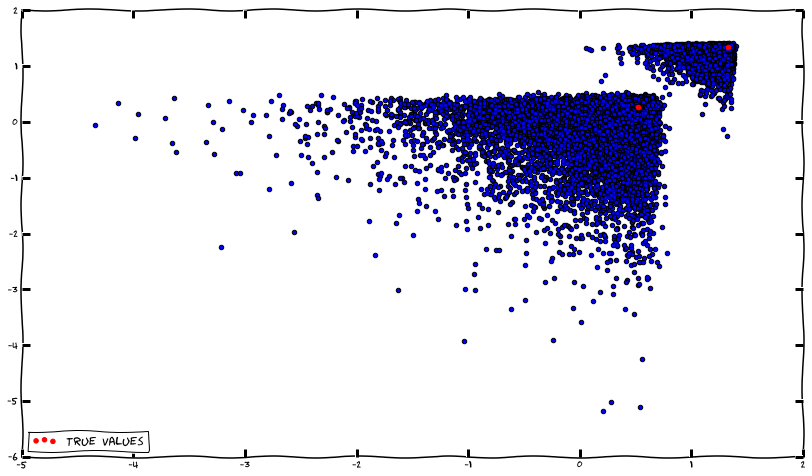

In [14]:
size = 10**4 #the number of sample points to generate

#simplify the random production of noise
def noise(mag, weightDiff, size,nMag = 0):
    totalWeight = np.array([1-weightDiff, weightDiff])*mag #combine the relative weight and the amplitude
    exp = -np.random.exponential(1,(size,2)) #the exponential portion of the noise
    norm = nMag*np.random.randn(size,2)+nMag*2 #the normal portion of the noise, so there's not a "wall" right at the value.
    return totalWeight*(exp+norm)
    
sampledAmps = np.array(noise(.7, .2, size, .1)+trueAmps).reshape((-1))
sampledRads = np.array(noise(.7, .2, size, .1)+trueRads).reshape((-1))
data = np.c_[sampledAmps, sampledRads] #combine into one array

#below, plot what we've generated. 
plt.subplot(121)
plt.title('Sampled Amplitudes')
plt.hist(sampledAmps, bins = 150)
plt.vlines(trueAmps, 0,1900, colors = 'r' )
plt.subplot(122)
plt.title('Sampled Radii')
plt.vlines(trueRads, 0, 1900, colors = 'r')
plt.hist(sampledRads, bins = 150)
plt.show()

plt.scatter(data[:,0], data[:,1])
plt.scatter(trueAmps, trueRads, color = 'r', label = 'True Values')
plt.legend(loc = 3)
plt.show()

This bears a stronger resemblance to the sample data. Let's see how scikit handles it. 

Recovered Vals:
[ 1.22825831  1.25816104]
[ 0.13201434 -0.1008753 ]
True Vals:
0.52319388257 0.274831238939
1.32592623183 1.35298358893


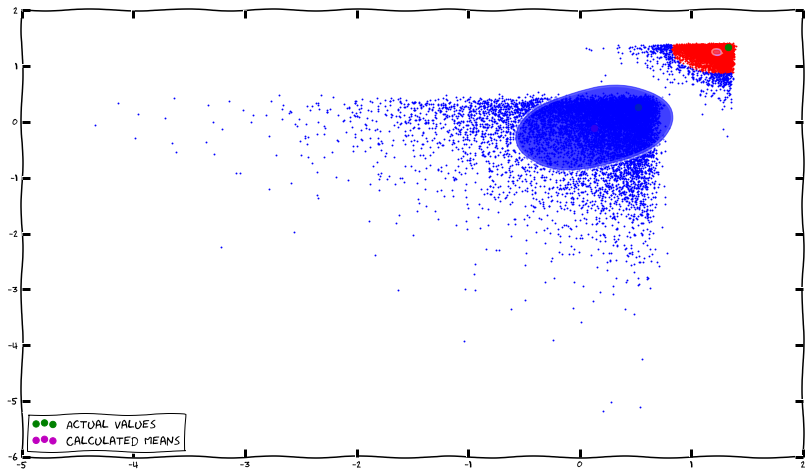

In [15]:
#a Gaussian Mixture Model of 2 components and full covariance. 
gmm = mixture.GMM(n_components = 2, covariance_type = 'full')
gmm.fit(data)

print "Recovered Vals:"
for mean in gmm.means_:
    print mean
    
print 'True Vals:'
for i in xrange(2):
    print trueAmps[i],trueRads[i]

#below, plot as before. 
classify = gmm.predict(data) #classify each point as in one peak or the other.
colors = ['r', 'b']
splot = plt.subplot(111)
#iterate over the gaussians that have been fit to
for i,(mean, covar,color) in enumerate(zip(gmm.means_, gmm.covars_, colors)):
    #eigenvalues and eigenvectors of covar matrix
    v,w = linalg.eigh(covar)
    
    #plot the points in the data
    plt.scatter(data[classify==i, 0], data[classify==i,1], .8, color = color)
    #Plot an ellipse
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180*angle/np.pi
    v*=4
    #plot a semi tranparent ellipse over the data
    ell = Ellipse(mean, v[0], v[1], 180+angle, color = color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)
plt.scatter(trueAmps, trueRads, s= 40, color = 'g', label = 'Actual Values')
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], s = 40, color = 'm', label = 'Calculated Means')
plt.legend(loc = 3)
plt.show()

#Uncomment to see corner plots as well
#fig = corner(data, labels = ['Amps', 'Rads'], truths = gmm.means_[0])
#plt.show()
#fig = corner(data, labels = ['Amps', 'Rads'], truths = gmm.means_[1])
#plt.show()

Decent, but not great. It's somehwat comforting to see that it's making a similar error to the real data, with the calculated values being pulled toward the lower left of the true values.

I think the inherent problem with this approach is that our data is truly non-gaussian, and we cannot apply a gaussian fit to it and expect good results. The thing is, we aren't interested in any of the parameters a gaussian fit may give us, we just want the data classified. Luckily, sklearn offers specialized clustering packages. Below I attempt to use those to select parameters. 

###Clustering

The mixture of gaussians fit does some clustering, but more as a side effect than an actual goal. The reality is, the data comes back in a non gaussian way, so a gaussian fit may not be a good direction. All we're interested in is identifying groups, and then picking the most selected point in those groups. 

Scikit learn also includes a package dedicated to clustering, I'll use that on the same data now, and select a mode from it. 

Calculated Values:
[[ 1.33  1.35]
 [ 0.57  0.32]]
True Vals:
0.52319388257 0.274831238939
1.32592623183 1.35298358893


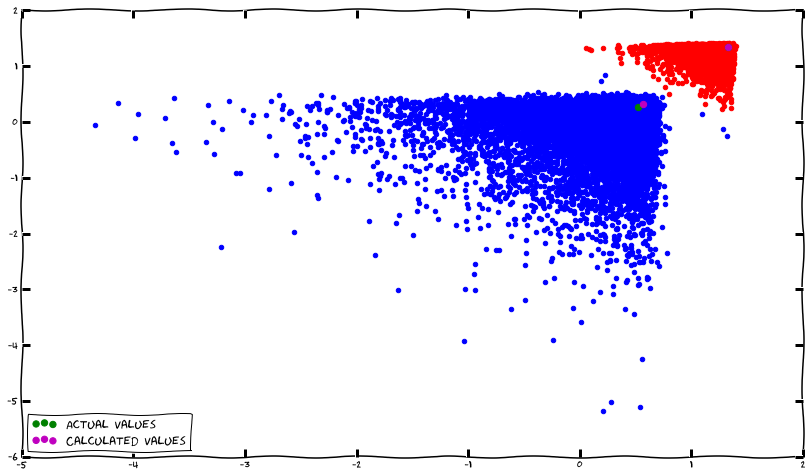

In [16]:
from scipy.stats import mode
from sklearn.cluster import KMeans

#Sklearn has several clustering packages. Kmeans is the fastest over large datasets
k_means = KMeans(init = 'k-means++', n_clusters = 2, n_init = 100)
k_means.fit(data)
labels = k_means.labels_

#separate the data into clusters
clusters = [data[labels == i] for i in xrange(2)]

#round to 2 decimals places for binning, so modes can actual count something
roundClusters = np.array([np.round(cluster, decimals = 2) for cluster in clusters]) 
modes = np.array([mode(cluster)[0] for cluster in roundClusters])[:,0,:]

#print values and plot
print 'Calculated Values:'
print modes

print 'True Vals:'
for i in xrange(2):
    print trueAmps[i],trueRads[i]
    
for i, color in enumerate(colors):
    idx = labels==i
    plt.scatter(data[idx][:,0], data[idx][:,1], color = color)
    
plt.scatter(trueAmps, trueRads, s= 40, color = 'g', label = 'Actual Values')
plt.scatter(modes[:,0], modes[:,1], s = 40, color = 'm', label = 'Calculated Values')
plt.legend(loc = 3)
plt.show()

As you can see, this works very well. Let's try it on real data. 

In [17]:
samples = np.loadtxt(filename, delimiter = ',')
sampled_amps = samples[:, :2].reshape((-1))
sampled_rads = samples[:, 2:].reshape((-1))
data = np.c_[sampled_amps, sampled_rads]

Calculated Values
[[ 1.72  1.03]
 [ 1.61  0.43]]


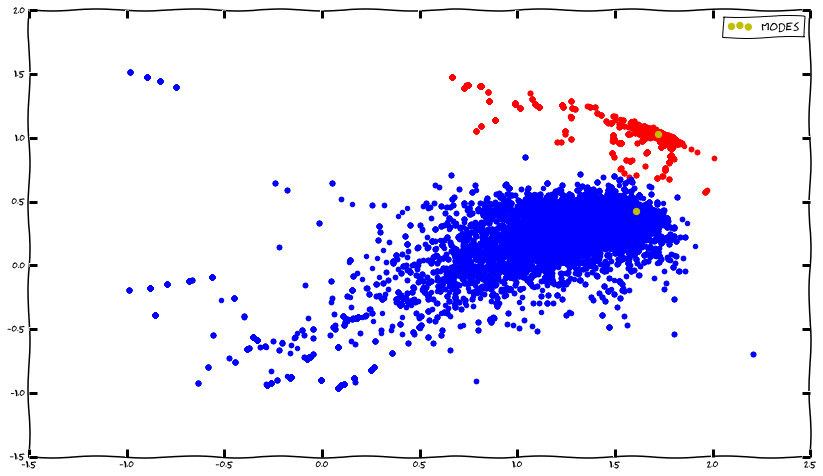

NameError: name 'corner' is not defined

In [18]:
k_means = KMeans(init = 'k-means++', n_clusters = 2, n_init = 100)
k_means.fit(data)
labels = k_means.labels_
for i, color in enumerate(colors):
    g = data[labels ==i]
    plt.scatter(g[:,0], g[:,1], color = color)

roundData = np.round(data, decimals = 2)
clusters =np.array([roundData[labels == i] for i in xrange(2)])

modes = np.array([mode(cluster)[0] for cluster in clusters])[:,0,:]
print 'Calculated Values'
print modes
    
plt.scatter(modes[:,0], modes[:,1], s = 40,color = 'y', label = 'Modes')
plt.legend()
plt.show()

fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[0])
plt.show()
fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[1])
plt.show()


Perfect. Now, though, let's see an example where this falls apart.  

In [19]:
#Make sure to change this to whatever it is on your machine.
filename = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/Samples/CFHTLS_047_1014_i'

In [20]:
samples = np.loadtxt(filename, delimiter = ',')
sampled_amps = samples[:, :2].reshape((-1))
sampled_rads = samples[:, 2:].reshape((-1))
data = np.c_[sampled_amps, sampled_rads]

Calculated Values
[[ 2.33  0.91]
 [ 0.17 -0.52]]


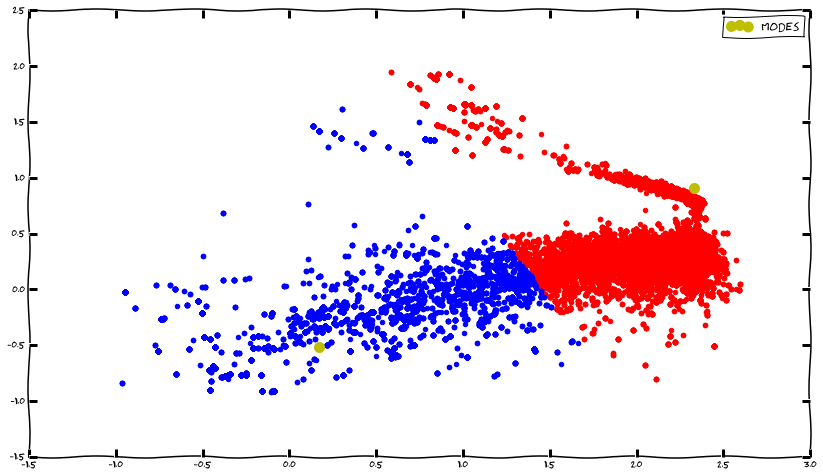

NameError: name 'corner' is not defined

In [21]:
k_means = KMeans(init = 'k-means++', n_clusters = 2, n_init = 10)
#similar procedure as above.
labels = k_means.fit_predict(data)
colors = ['r','b']
for i, color in enumerate(colors):
    g = data[labels ==i]
    plt.scatter(g[:,0], g[:,1], color = color)

roundData = np.round(data, decimals = 2)
clusters =np.array([roundData[labels == i] for i in xrange(2)])

modes = np.array([mode(cluster)[0] for cluster in clusters])[:,0,:]
print 'Calculated Values'
print modes
    
plt.scatter(modes[:,0], modes[:,1], s = 100,color = 'y', label = 'Modes')
plt.legend()
plt.show()

fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[0])
plt.show()
fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[1])
plt.show()


Failure. To show how bad of one, below I print the average count (numer of occurences) for the peak in the 2 clusters.

In [22]:
print [mode(cluster)[1].mean() for cluster in clusters]

[11276.5, 235.5]


Big difference. The second selected parameter is nowhere near the first. There are a few possible solutions, but all have their drawbacks. K-means is only one of several clustering algorithms. However, it's also the only one computationaly efficient over the sample size we have. Agglomerative clustering would be the one we want to use for our sample, but it does not scale well to our sample size. It's possible to improve computation by passing in a connectivity matrix, but in practice it doesn't seem to be enough. 

The other option is instead of using k-means with 2 clusters, to use 3. 2 primary clusters and one "noise" cluster. It'll be fast, but still may not work as designed. Testing both below. 

/home/jeffrey/anaconda2/lib/python2.7/site-packages/sklearn/neighbors/graph.py:37: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)
/home/jeffrey/anaconda2/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:443: UserWarning: the number of connected components of the connectivity matrix is 5 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)
/home/jeffrey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 200000 but corresponding boolean dimensio

[[ 2.36  0.35]
 [ 2.13  0.92]]
[array([[272, 386]]), array([[357, 424]])]


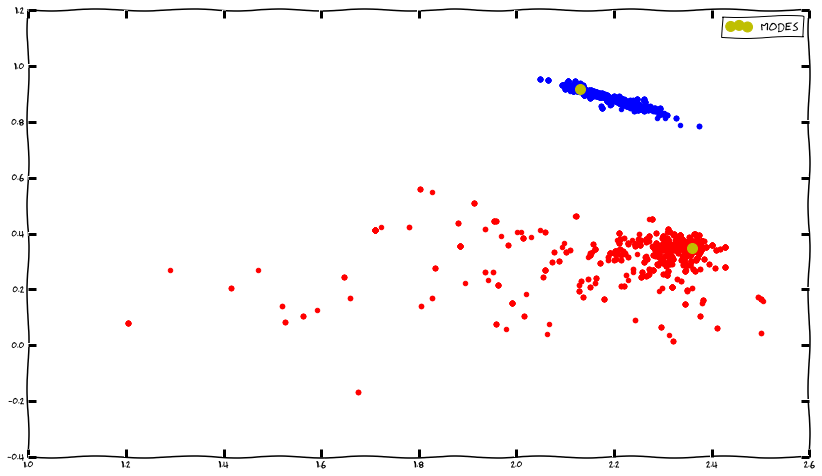

NameError: name 'corner' is not defined

In [23]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
#I encourage you to play with different slices and nNeighbors
#It leads to many different results
#one of the results is of course ipython using all your RAM
#by making a 200,000x200,000 connectivity matrix, so be careful.
nPassedIn = 5000
nNeighbors = 25
knn_graph = kneighbors_graph(data[:nPassedIn], nNeighbors) 

model = AgglomerativeClustering(linkage = 'average', connectivity = knn_graph, n_clusters = 2)

model.fit(data[:nPassedIn])

labels = model.labels_
for i, color in enumerate(colors):
    g = data[labels ==i]
    plt.scatter(g[:,0], g[:,1], color = color)

clusters =np.array([roundData[labels == i] for i in xrange(2)])

modes = np.array([mode(cluster)[0] for cluster in clusters])[:,0,:]
print modes
print [mode(cluster)[1] for cluster in clusters]
    
plt.scatter(modes[:,0], modes[:,1], s = 100,color = 'y', label = 'Modes')
plt.legend()
plt.show()

fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[0])
plt.show()
fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[1])
plt.show()


That worked well but it's still a computational challenge. If you do not slice the data down to a smaller size it will crash your machine (I found out the hard way). Below I try using 3 clusters with k-means. 

[(array([[ 2.14,  0.91]]), 10499.5), (array([[ 2.35,  0.36]]), 8657.0), (array([[ 2.02,  0.24]]), 497.0), (array([[-0.09, -0.77]]), 220.0), (array([[ 1.05,  1.62]]), 144.0), (array([[ 0.61, -0.4 ]]), 132.5)]


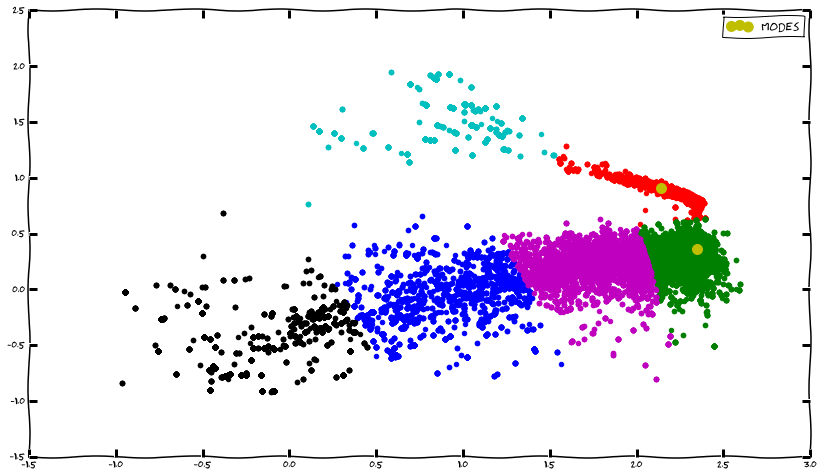

NameError: name 'corner' is not defined

In [24]:
n_clusters = 6
k_means = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 10)

#get labels and plot the clusters
labels = k_means.fit_predict(data)
colors = ['r','b','g','c','m','k']
for i, color in enumerate(colors):
    g = data[labels ==i]
    plt.scatter(g[:,0], g[:,1], color = color)

#round out the clusters for binning
roundData = np.round(data, decimals = 2)
clusters =np.array([roundData[labels == i] for i in xrange(n_clusters)])

#get a list of the points and their average count. 
allModes = []
for cluster in clusters:
    point, counts = mode(cluster)
    allModes.append((point, counts.mean()))

#the modes with the highest avg count will be the values we're interested in. 
allModes.sort(key= lambda f:f[1], reverse = True) #sort by highest counts
print allModes
modes = np.r_[allModes[0][0], allModes[1][0]]
    
plt.scatter(modes[:,0], modes[:,1], s = 100,color = 'y', label = 'Modes')
plt.legend()
plt.show()

fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[0])
plt.show()
fig = corner(data, labels = ['Amps', 'Rads'], truths = modes[1])
plt.show()


That worked pretty much perfectly. Also, this approach allows for increasing the number of clusters if there is still trouble, and still works fine. I'll attempt to implement it in my full program. 

###Dirichlet Process GMM
I do want to check that I'm not placing an unfair bias on my sample by assuming a number of clusters. I'll throw in one last try with sklearn's DPGMM, which calculates an ideal number of clusters for the distribution. It is Gaussian in nature though, so I'm concerned it may not behave as I'd like.  

Recovered Vals:
[ 2.13340487  0.58826678]
[ 2.13340965  0.58826912]
[ 2.13338255  0.58826002]
[ 2.13297715  0.58810377]
[ 2.13337275  0.58825672]
[ 2.13334451  0.58824714]
True Vals:
0.52319388257 0.274831238939
1.32592623183 1.35298358893
1.0
0 not in classify
2 not in classify
3 not in classify
4 not in classify
5 not in classify


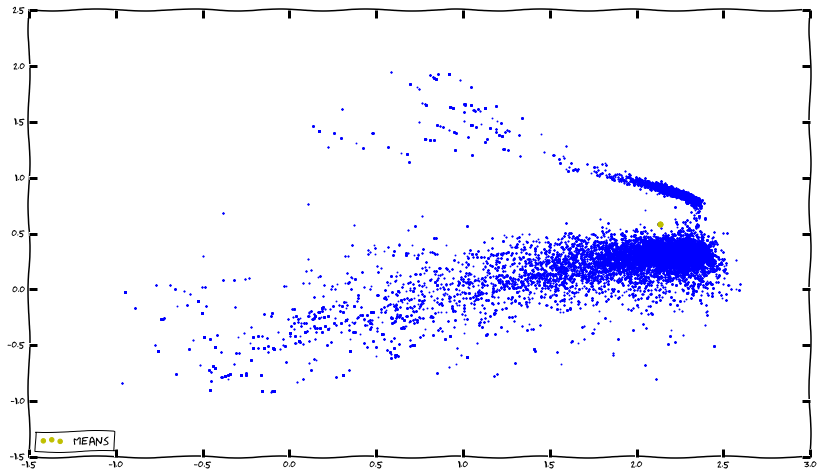

In [25]:
from sklearn.mixture import DPGMM 
dpgmm = mixture.DPGMM(alpha = 100000,n_components = 6,covariance_type = 'tied')
dpgmm.fit(data)

print "Recovered Vals:"
for mean in dpgmm.means_:
    print mean
    
print 'True Vals:'
for i in xrange(2):
    print trueAmps[i],trueRads[i]

classify = dpgmm.predict(data) #classify each point as in one peak or the other.
print classify.mean()
splot = plt.subplot(111)
#iterate over the gaussians that have been fit to
for i,(mean,color) in enumerate(zip(dpgmm.means_,colors)):
    #plot the points in the data
    if i not in classify:
        print '%d not in classify'%i
    plt.scatter(data[classify==i, 0], data[classify==i,1], .8, color = color)
    
plt.scatter(dpgmm.means_[:,0], dpgmm.means_[:,1], color = 'y', label = 'Means')
plt.legend(loc = 3)
plt.show()